### Streaming

In [20]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, RemoveMessage
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os
load_dotenv()

True

In [21]:
class State(MessagesState):
    summary: str

In [23]:
CHAT_LLAMA=os.getenv("CHAT_LLAMA")

In [24]:
model = ChatGroq(model=CHAT_LLAMA)

In [25]:
def conversation(state:State, config:RunnableConfig):
    summary = state.get("summary")
    if summary:
        message = f"Here's the summary of our conversation so far:{summary} answer the following keeping the summary in context"
        query = [[HumanMessage(content=message)]+state['messages']]
    else:
        query=state['messages']

    response = model.invoke(query, config)
    return {"messages":response}

In [26]:
def summarization(state:State):
    summary = state.get("summary")

    if summary:
        system_message = f"use the following earlier summary: {summary}, and create a new summary using the following new conversation: {state['messages']}"
        message = [[HumanMessage(content=system_message)]+state['messages']]
    else:
        system_message = f"create a summary of the following conversation: {state['messages']}"
        message=[HumanMessage(content=system_message)]
    
    response = model.invoke(message)
    recent_messages=[RemoveMessage(id=m.id) for m in state['messages'][:-2]]

    return {'messages':recent_messages,'summary':response.content}


In [27]:
def should_continue(state:State):
    messages = state['messages']
    if len(messages)>=6:
        return 'summ'
    else:
        return END

In [28]:
memory = MemorySaver()
builder = StateGraph(State)

# nodes
builder.add_node('conv',conversation)
builder.add_node('summ',summarization)

# edges
builder.add_edge(START,'conv')
builder.add_conditional_edges('conv',should_continue)
builder.add_edge('summ',END)

graph = builder.compile(memory)

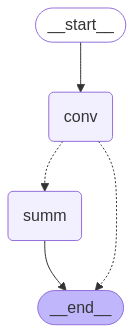

In [29]:
graph

#### Streaming full state
LangGraph supports a few different streaming modes for graph state:

updates: This streams updates to the state of the graph after each node is called.

In [30]:
config = {"configurable":{"thread_id":"1"}}

for chunk in graph.stream({"messages":HumanMessage(content="Hi my name is jerry")}, config=config, stream_mode="updates"):
    print(chunk)


{'conv': {'messages': AIMessage(content='Hello Jerry! Nice to meet you! Is there something I can help you with or would you like to chat?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 16, 'total_tokens': 40, 'completion_time': 0.100202862, 'prompt_time': 0.006885726, 'queue_time': 0.084150714, 'total_time': 0.107088588}, 'model_name': 'meta-llama/llama-4-maverick-17b-128e-instruct', 'system_fingerprint': 'fp_253f463456', 'finish_reason': 'stop', 'logprobs': None}, id='run-e89bcaf1-4790-4e02-ba9c-53e59004351c-0', usage_metadata={'input_tokens': 16, 'output_tokens': 24, 'total_tokens': 40})}}


In [33]:
for chunk in graph.stream({"messages":HumanMessage(content="I hate cats!")}, config=config, stream_mode="updates"):
    print(chunk)

{'conv': {'messages': AIMessage(content="Well, Jerry, it seems like you're not a fan of our feline friends. That's perfectly okay! People have different preferences when it comes to pets. What is it about cats that you don't like? Is there a particular reason or experience that's led you to feel this way?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 53, 'total_tokens': 110, 'completion_time': 0.236577561, 'prompt_time': 0.008145777, 'queue_time': 0.229402732, 'total_time': 0.244723338}, 'model_name': 'meta-llama/llama-4-maverick-17b-128e-instruct', 'system_fingerprint': 'fp_253f463456', 'finish_reason': 'stop', 'logprobs': None}, id='run-bc501493-4912-4f47-a96d-5ec2b9b602c1-0', usage_metadata={'input_tokens': 53, 'output_tokens': 57, 'total_tokens': 110})}}


values: This streams the full state of the graph after each node is called.

In [43]:
config = {"configurable":{"thread_id":"3"}}

In [44]:
for event in graph.stream({"messages":[HumanMessage(content="Hey, im tom")]}, config=config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
        print("---"*25)

================================ Human Message =================================

Hey, im tom
---------------------------------------------------------------------------
================================ Human Message =================================

Hey, im tom
---------------------------------------------------------------------------
================================== Ai Message ==================================

Hey Tom! Nice to meet you. How's it going?
---------------------------------------------------------------------------


### Streaming tokens